In [1]:
dir_data = '../data'
outside_fname = '/home/eunwoo/experiment/PSSC/Oneformer(instance)/result/background7_abandon65/total_sum_bg.pickle'

In [2]:
import sys
sys.path.append('../')

import os

import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

from tqdm import tqdm

from segformers.utils import custom_cmap, rle_encode
from segformers.losses import label_to_one_hot_label

/home/dongjin/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(os.path.join(dir_data, 'test.csv'))

with open(outside_fname, 'rb') as f:
    outside2 = pickle.load(f)[0]
outside2 = cv2.resize(outside2, (960, 540), interpolation=cv2.INTER_NEAREST)


In [4]:
def rle2mask(mask_rle, label=1, shape=(540, 960)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = label
    return img.reshape(shape)
    

In [5]:
path_cand1 = '/home/shlee/shlee/2023_Samsung_AI_Challenge_DA/ckpt/1695994463/logits_tensors'
path_cand2 = '/home/dongjin/projects/da/notebooks/logits_newpl'
path_cand3 = '/home/dongjin/projects/da/notebooks/logits_dice2'
path_cand4 = 'Final_Top_M2F.csv'

cand4_csv = pd.read_csv(path_cand4)

i = 0
row = 0
masks = []
result = []

for i in tqdm(range(len(df))):
    cand1 = torch.load(os.path.join(path_cand1, f'prediction_{i}.pt'), map_location='cpu')
    cand1 = torch.softmax(cand1, dim=1)[0].cpu().numpy()
    
    cand2 = np.load(os.path.join(path_cand2, f'{i}.npy'))[np.newaxis]
    cand2 = torch.as_tensor(cand2)
    cand2 = torch.softmax(cand2, dim=1)[0].cpu().numpy()
    outside1 = np.argmax(cand2, axis=0) == 12
    
    cand3 = np.load(os.path.join(path_cand3, f'{i}.npy'))[np.newaxis]
    cand3 = torch.as_tensor(cand3)
    cand3 = torch.softmax(cand3, dim=1)[0].cpu().numpy()
    
    cand4_mask = np.zeros((540, 960)) + 12
    for c in range(12):
        if not cand4_csv.loc[row, 'mask_rle'] == '-1':
            m = rle2mask(cand4_csv.loc[row, 'mask_rle'], label=1)
            cand4_mask[np.where(m == 1)] = c
        row +=1
    cand4 = label_to_one_hot_label(torch.as_tensor(cand4_mask).unsqueeze(0).long(), 13).float() * 0.90
    cand4 = cand4.cpu().numpy()[0]
    
    logit = (cand1 + cand2 + cand3 + cand4) / 4.0
    mask = logit.argmax(axis=0).astype(np.int32)

    # Remove noise
    # bincount = np.bincount(mask.flatten())
    # noise_classes = np.where((bincount > 0) & (bincount < 50))[0]
    # if len(noise_classes) > 0:
    #     for c in noise_classes:
    #         if c != 5:
    #             mask[np.where(mask == c)] = 12
                
    mask[np.where(outside1 == 1)] = 12
    mask[np.where(outside2 == 1)] = 12

    # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
    for class_id in range(12):
        class_mask = (mask == class_id).astype(np.int32)
        if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
            mask_rle = rle_encode(class_mask)
            result.append(mask_rle)
        else: # 마스크가 존재하지 않는 경우 -1
            result.append(-1)
            
    masks.append(mask)

100%|██████████| 1898/1898 [04:01<00:00,  7.85it/s]


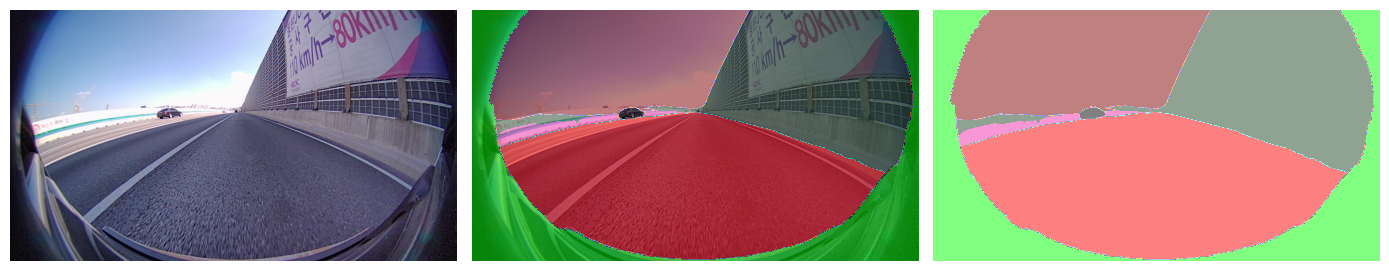

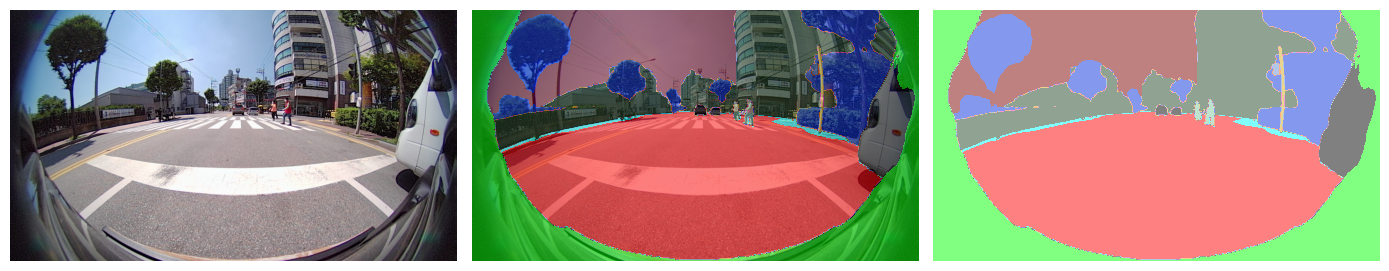

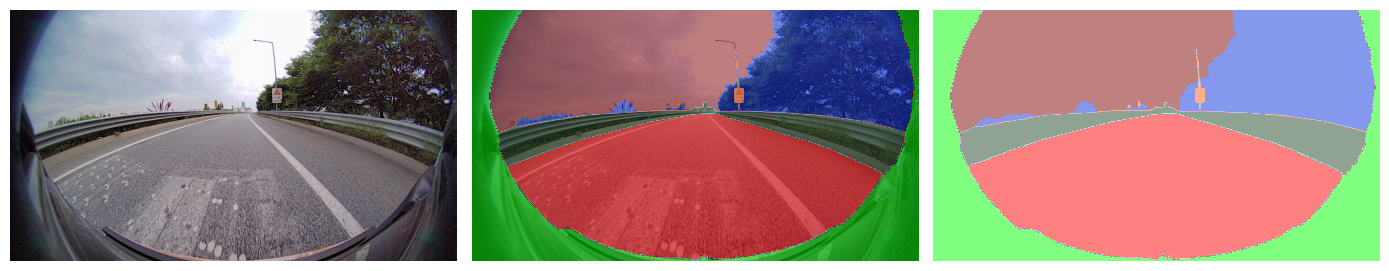

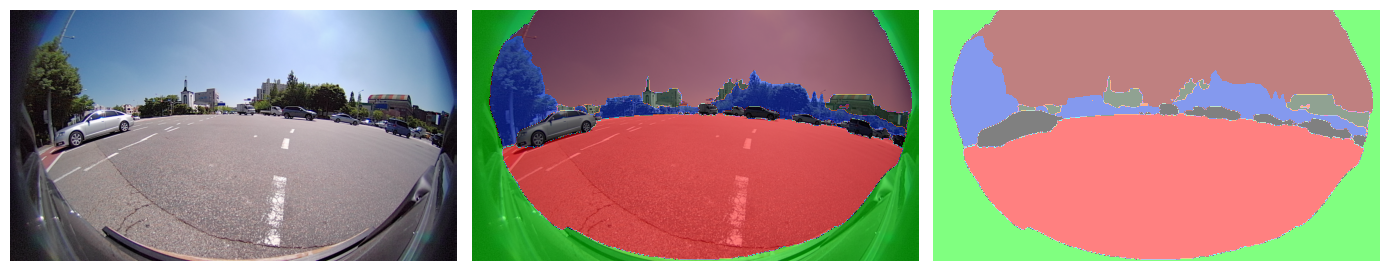

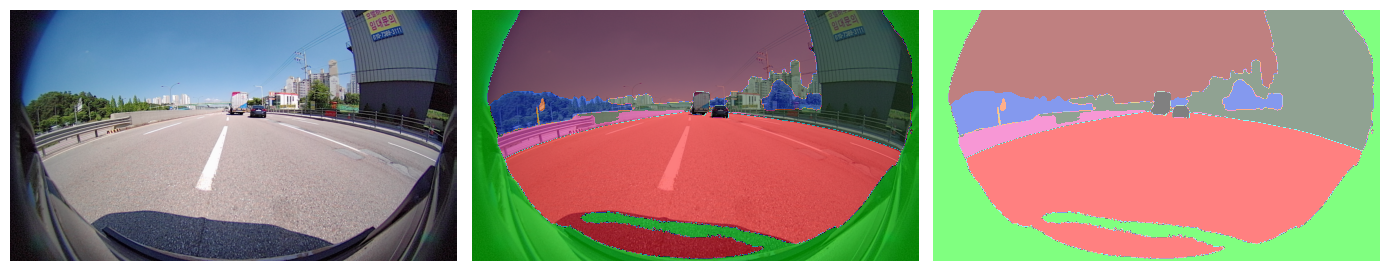

In [6]:
for idx in range(len(df))[:5]:
    img_path = os.path.join(dir_data, df.loc[idx, 'img_path'])
    image = cv2.imread(img_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (960, 540))
    
    mask = masks[idx]

    fig, ax = plt.subplots(1, 3, figsize=(14, 10))

    ax[0].axis('off')
    ax[0].imshow(image)

    ax[1].axis('off')
    ax[1].imshow(image)
    im = ax[1].imshow(mask, alpha=0.5, cmap=custom_cmap)

    ax[2].axis('off')
    im = ax[2].imshow(mask, alpha=0.5, cmap=custom_cmap)

    fig.tight_layout()
    
    plt.show()

In [7]:
submit = pd.read_csv('../data/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,212628 5 212636 5 213573 1 213585 1 213587 24 ...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,598 276 1558 276 2517 278 3476 279 4436 280 53...
3,TEST_0000_class_3,207757 2 208707 21 209656 53 210608 74 210696 ...
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,152250 8 153208 28 154166 35 155124 38 156083 ...
22772,TEST_1897_class_8,103 532 677 127 857 5 1062 533 1637 127 1817 5...
22773,TEST_1897_class_9,-1
22774,TEST_1897_class_10,-1


In [8]:
submit.to_csv('./AverageEnsemble_Raw.csv', index=False)